<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Импортируем нужные библиотеки для работы с данными, кластеризацией и визуализацией
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances

import warnings
warnings.filterwarnings('ignore')

# Загружаю данные из GitHub, беру только числовые признаки для анализа
url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = pd.read_csv(url)

features = [
    'debts', 'bequests', 'wife', 'husband',
    'sons', 'daughters', 'father', 'mother',
    'brothers', 'sisters'
]

# Выбираю нужные признаки и заполняю пропуски медианой, чтобы не было проблем с алгоритмами
X = df[features].copy()
X.fillna(X.median(), inplace=True)


In [17]:
# Масштабирую данные, чтобы признаки были в одном масштабе - это важно для кластеризации
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Снижаю размерность до 2 для удобной визуализации с помощью PCA
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)


In [18]:
# Функция для расчёта основных метрик качества кластеризации
def evaluate_clustering(X, labels):
    # Если кластеров меньше двух - метрики считать нельзя, возвращаю None
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or (unique_labels == {-1}):
        return None, None, None
    # Вычисляю силуэт, Калински-Харабаш и Дэвис-Болдин
    return (
        silhouette_score(X, labels),
        calinski_harabasz_score(X, labels),
        davies_bouldin_score(X, labels)
    )

# Функция для вычисления индекса Данна - показывает, насколько кластеры плотные и хорошо отделены
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) <= 1 or (set(unique_clusters) == {-1}):
        return None

    distances = pairwise_distances(X)
    intra_dists = []
    inter_dists = []

    # Максимальное внутрикластерное расстояние для каждого кластера
    for c in unique_clusters:
        if c == -1:
            continue
        indices = np.where(labels == c)[0]
        if len(indices) > 1:
            intra_dists.append(np.max(distances[np.ix_(indices, indices)]))

    # Минимальное межкластерное расстояние между кластерами
    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            if -1 in (unique_clusters[i], unique_clusters[j]):
                continue
            i_idx = np.where(labels == unique_clusters[i])[0]
            j_idx = np.where(labels == unique_clusters[j])[0]
            inter_dists.append(np.min(distances[np.ix_(i_idx, j_idx)]))

    if intra_dists and inter_dists:
        return min(inter_dists) / max(intra_dists)
    else:
        return None


In [19]:
# Функция для визуализации кластеров на 2D графике с помощью PCA
def plot_clusters(pca_data, labels, title):
    unique_labels = set(labels) - {-1}
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(10, 6))
    for k, col in zip(unique_labels, colors):
        mask = (labels == k)
        plt.scatter(
            pca_data[mask, 0], pca_data[mask, 1],
            c=[col],
            label=f'Cluster {k}',
            s=50, edgecolor='k'
        )

    # Отдельно показываю шумовые точки, если они есть (для DBSCAN)
    noise_mask = (labels == -1)
    if np.any(noise_mask):
        plt.scatter(
            pca_data[noise_mask, 0], pca_data[noise_mask, 1],
            c='grey', label='Noise', s=50, edgecolor='k', marker='x'
        )

    sil, ch, db = evaluate_clustering(pca_data, labels)
    if sil is not None:
        metrics = f"Silhouette: {sil:.2f} | Calinski-Harabasz: {ch:.2f} | Davies-Bouldin: {db:.2f}"
    else:
        metrics = "Недостаточно кластеров для оценки"
    plt.title(f"{title}\n{metrics}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


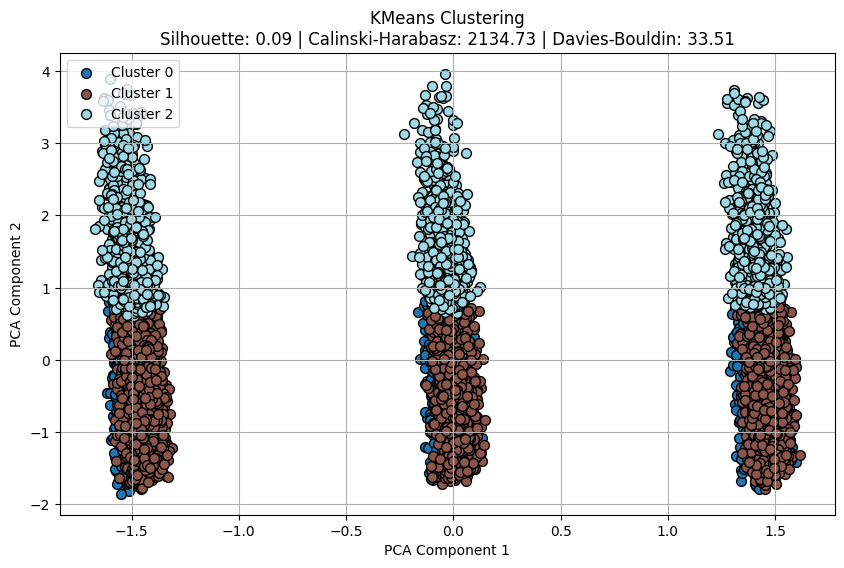

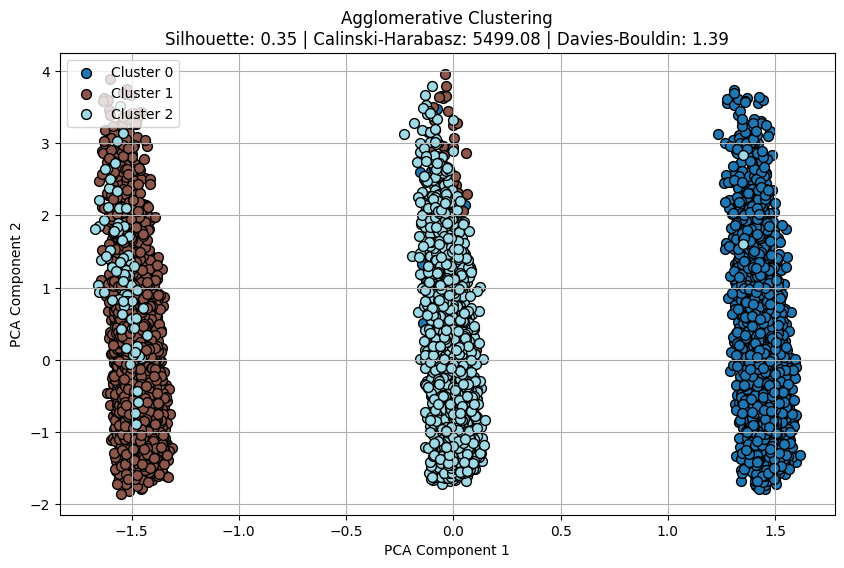

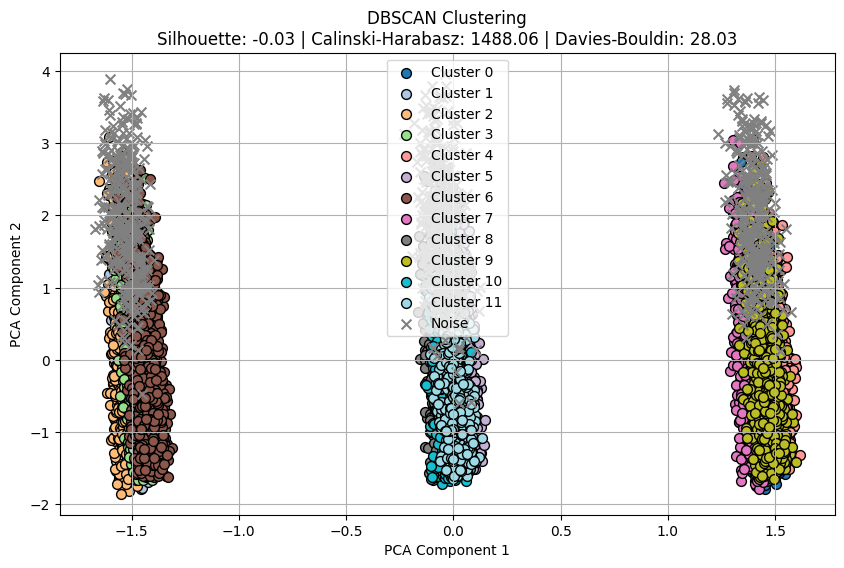

In [20]:
# Запускаю KMeans с 3 кластерами и визуализирую
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(scaled_data)
plot_clusters(pca_data, labels_kmeans, "KMeans Clustering")

# Запускаю иерархическую агломеративную кластеризацию с 3 кластерами и визуализирую
agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(scaled_data)
plot_clusters(pca_data, labels_agglo, "Agglomerative Clustering")

# Запускаю DBSCAN с eps=1.5 и min_samples=10 и визуализирую
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(scaled_data)
plot_clusters(pca_data, labels_dbscan, "DBSCAN Clustering")



Сводная таблица метрик кластеризации:
               Silhouette  Calinski-Harabasz  Davies-Bouldin  Dunn Index
KMeans           0.092958         967.563533        2.684941    0.012390
Agglomerative    0.107602        1143.151377        2.866855    0.098264
DBSCAN           0.131020         563.362558        2.247021    0.294513


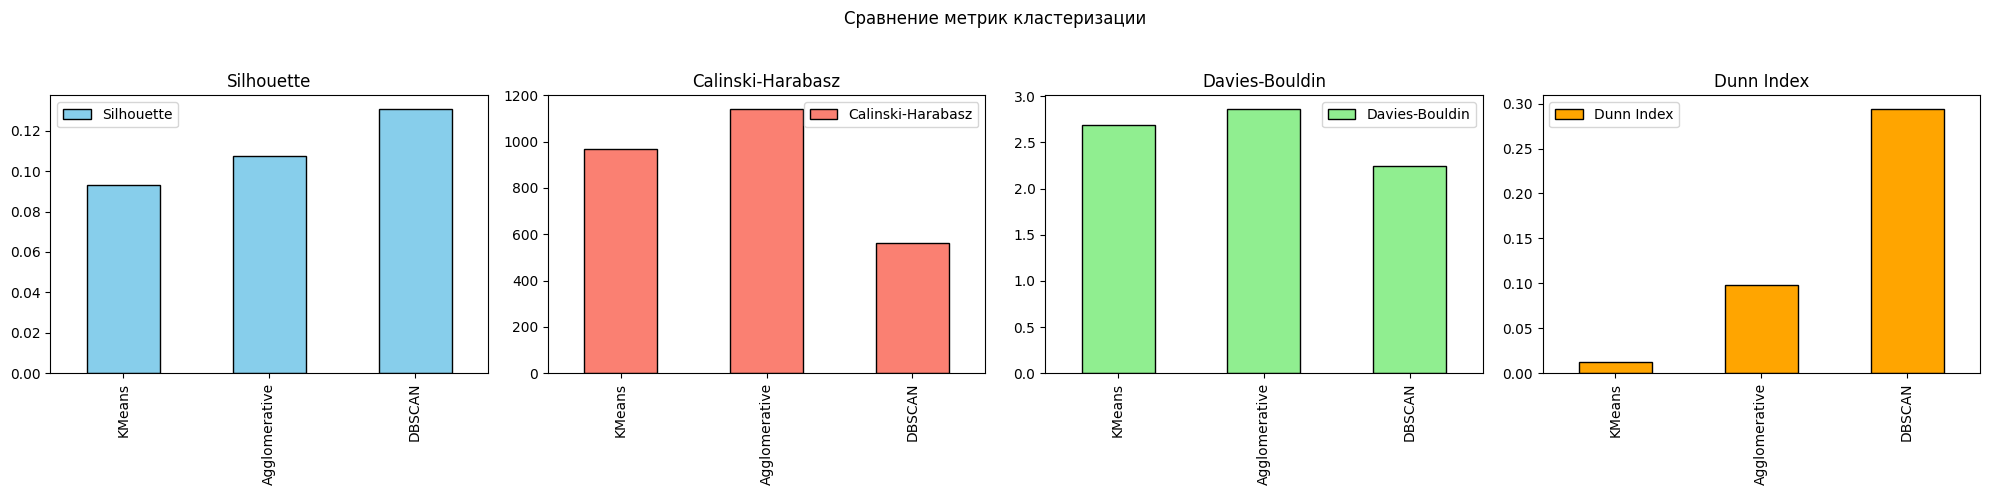

In [21]:
# Считаю метрики для всех трёх алгоритмов, чтобы сравнить качество кластеризации
metrics = {
    'Silhouette': [
        silhouette_score(scaled_data, labels_kmeans),
        silhouette_score(scaled_data, labels_agglo),
        silhouette_score(scaled_data, labels_dbscan)
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(scaled_data, labels_kmeans),
        calinski_harabasz_score(scaled_data, labels_agglo),
        calinski_harabasz_score(scaled_data, labels_dbscan)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(scaled_data, labels_kmeans),
        davies_bouldin_score(scaled_data, labels_agglo),
        davies_bouldin_score(scaled_data, labels_dbscan)
    ],
    'Dunn Index': [
        dunn_index(scaled_data, labels_kmeans),
        dunn_index(scaled_data, labels_agglo),
        dunn_index(scaled_data, labels_dbscan)
    ]
}

results_df = pd.DataFrame(metrics, index=['KMeans', 'Agglomerative', 'DBSCAN'])
print("\nСводная таблица метрик кластеризации:")
print(results_df)

# Визуализирую сравнение метрик для наглядности
results_df.plot(kind='bar', subplots=True, layout=(1, 4), figsize=(20, 5),
                color=['skyblue', 'salmon', 'lightgreen', 'orange'], edgecolor='k')
plt.suptitle("Сравнение метрик кластеризации")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
